## A1. Dataset and Setup

#### Import required libraries

In [101]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### Load dataset

In [44]:
digits = load_digits()
print(digits.data.shape)

(1797, 64)


#### Data splitting

In [45]:
X, y = digits['data'], digits['target']

# split into train (70%) and temp (30%)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, temp_index in sss1.split(X, y):
    X_train, X_temp = X[train_index], X[temp_index]
    y_train, y_temp = y[train_index], y[temp_index]

# split temp into validation (50% of temp) and test (50% of temp)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in sss2.split(X_temp, y_temp):
    X_validation, X_test = X_temp[val_index], X_temp[test_index]
    y_validation, y_test = y_temp[val_index], y_temp[test_index]

#### Check shapes

In [46]:
print("Train:", X_train.shape, "Validation:", X_validation.shape, "Test:", X_test.shape)

Train: (1257, 64) Validation: (270, 64) Test: (270, 64)


####  Check class distribution

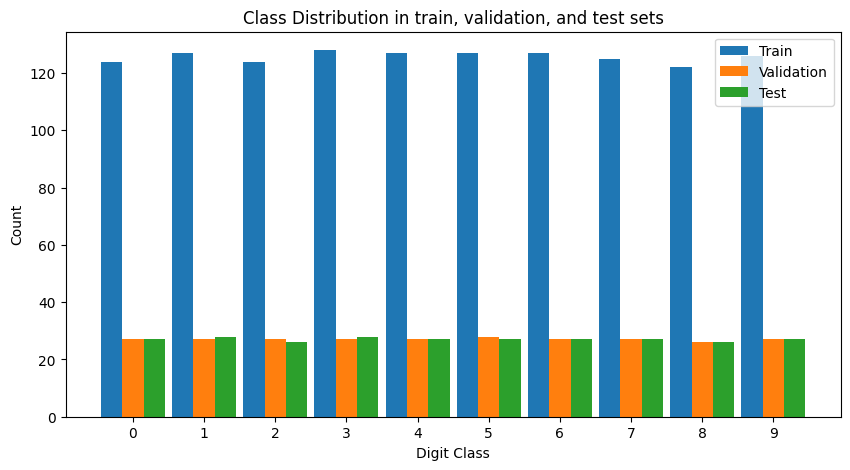

In [47]:
# Count labels
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_validation)
test_counts = np.bincount(y_test)
labels = np.arange(len(train_counts))   # digits 0–9
# Create bar width & positions
width = 0.3
x = np.arange(len(labels))
plt.figure(figsize=(10,5))
plt.bar(x - width, train_counts, width, label="Train")
plt.bar(x,         val_counts,  width, label="Validation")
plt.bar(x + width, test_counts, width, label="Test")

plt.xlabel("Digit Class")
plt.ylabel("Count")
plt.title("Class Distribution in train, validation, and test sets")
plt.xticks(labels)
plt.legend()
plt.show()

#### Data standardization

In [48]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)

sc.fit(X_validation)
X_validation = sc.transform(X_validation)

sc.fit(X_test)
X_test = sc.transform(X_test)

## A2. Gaussian Generative Model

#### 1. Estimate the class priors
**Class prior** refers to the probability of each class occurring in a dataset **before observing any features**. In other words, it represents our initial belief about how likely each class is, based purely on the distribution of labels in the training data

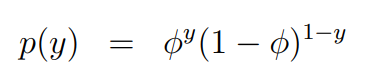

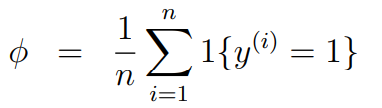

In [49]:
pi = np.bincount(y_train) / len(y_train)
# print("Class priors:", pi)

#### 2. Estimate the class means
**Class Mean ( 𝜇𝑐):** The average feature vector of all samples in a class
𝑐. It represents the **center** of that class in feature space

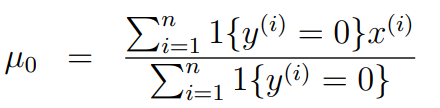

In [50]:
mu = np.array([X_train[y_train == k].mean(axis=0) for k in range(10)])
# print("Class means:", mu)

#### 3. Estimate the shared covariance matrix
Covariance Matrix (Σ𝑐): Measures how the features of class
𝑐 **vary and correlate with each other**. It captures the shape and orientation of the class distribution

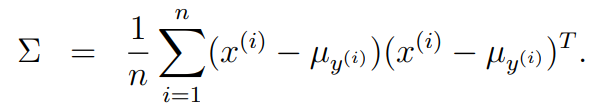

In [51]:
N, D = X_train.shape
cov = np.zeros((D, D))

diff = X_train - mu[y_train]
cov = diff.T @ diff / N
# print("covariance matrix : ", cov)

### I combined the logic of model training in one function

In [75]:
def train_model(X_train, y_train, l=0):
  pi = np.bincount(y_train) / len(y_train)
  mu = np.array([X_train[y_train == k].mean(axis=0) for k in range(10)])
  N, D = X_train.shape
  cov = np.zeros((D, D))

  diff = X_train - mu[y_train]
  cov = diff.T @ diff / N
  cov = cov + l * np.eye(64)
  return pi, mu, cov

### 4. Regularise the covariance

We need to add a small regularization term
𝜆𝐼 to the covariance matrix to ensure it is numerically stable and invertible. Without it, features with zero variance, highly correlated features, or a small number of samples relative to feature dimension can make the covariance matrix singular or nearly singular. Regularization slightly increases the diagonal values, preventing zero or very small eigenvalues, which allows the matrix to be safely inverted and ensures stable computations in Gaussian generative models.

In [52]:
lambda_ = 1e-3
cov_reg = cov + lambda_ * np.eye(64)
# print("covariance matrix : ", cov)

## Prediction Rule

For a new input `x`, we compute a score for each class `k` proportional to the log-posterior:

$$
\text{score}_k = \log \pi_k + \log \mathcal{N}(x \mid \mu_k, \Sigma_\lambda)
$$

- $\pi_k$ is the class prior, $\mu_k$ is the class mean, and $\Sigma_\lambda$ is the regularized shared covariance.  
- We **do not need the exact probability**, only comparable scores.  
- The predicted class is the one with the **largest score**:

$$
\hat{y} = \arg\max_k \text{score}_k
$$

In [55]:
def predict(X, pi, mu, cov_reg):
  cov_inv = np.linalg.inv(cov_reg)
  log_det = np.linalg.slogdet(cov_reg)[1]
  scores = []

  for x in X:
    score_k = []
    for k in range(len(pi)):
      diff = x - mu[k]
      score = np.log(pi[k]) - 0.5 * diff.T @ cov_inv @ diff - 0.5 * log_det
      score_k.append(score)
    scores.append(score_k)
  return np.argmax(scores, axis=1)


## A3. Hyperparameter Tuning and Evaluation

In [60]:
lambdas = [1e-4, 1e-3, 1e-2, 1e-1]

In [61]:
best_lambda = None
best_val_accuracy = 0
results = []

In [62]:
for l in lambdas:
  cov_reg = cov_reg + (l * np.eye(64))
  y_pred_list = []

  for x in X_validation:
      y_pred = predict(x[np.newaxis, :], pi, mu, cov_reg)
      y_pred_list.append(y_pred[0])

  y_pred_array = np.array(y_pred_list)
  accuracy = np.mean(y_pred_array == y_validation)
  results.append((l, accuracy))
  if accuracy > best_val_accuracy:
    best_val_accuracy = accuracy
    best_lambda = l


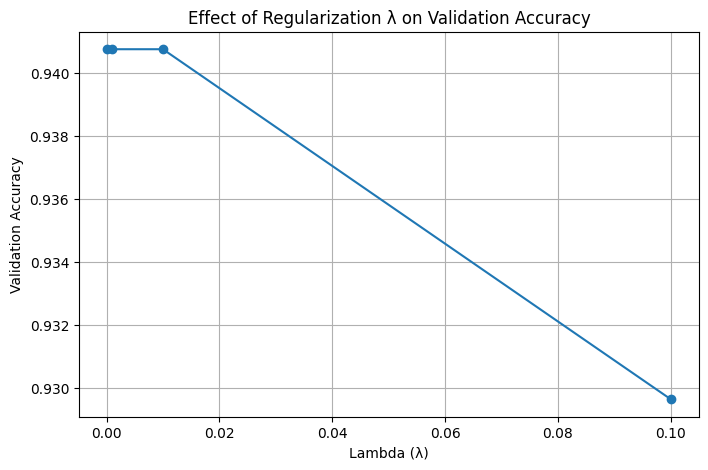

In [112]:
l_values = [item[0] for item in results]
accuracies = [item[1] for item in results]

plt.figure(figsize=(8, 5))
plt.plot(l_values, accuracies, marker='o')
plt.xlabel("Lambda (λ)")
plt.ylabel("Validation Accuracy")
plt.title("Effect of Regularization λ on Validation Accuracy")
plt.grid(True)
plt.show()

### 3. Select the value of λ that gives the best validation accuracy.

In [71]:
print("best accuracy = {:.2f} and best lambda = {}".format(best_val_accuracy, best_lambda))

best accuracy = 0.94 and best lambda = 0.0001


### 4. Final model

#### Combine the training and validation sets into a single training set.

In [78]:
X_combined = np.concatenate((X_train, X_validation), axis=0)
y_combined = np.concatenate((y_train, y_validation), axis=0)

#### Retrain Gaussian generative classifier on this combined set using the chosen λ.

In [79]:
pi, mu, cov = train_model(X_combined, y_combined, best_lambda)

#### Evaluate the final model on the test set only once.

In [85]:
def test(X_test, y_test):
  y_pred_list = []
  for x in X_test:
    prediction = predict(x[np.newaxis, :], pi, mu, cov)
    y_pred_list.append(prediction[0])

  y_pred = np.array(y_pred_list)
  accuracy = np.mean(y_pred == y_test)
  return y_pred, accuracy

In [88]:
y_pred, test_accuracy = test(X_test, y_test)

#### Final Report

##### Test accuracy

In [89]:
print("Test accuracy = {:.2f}".format(test_accuracy))

Test accuracy = 0.96


#### Macro-averaged precision

In [92]:
prec = precision_score(y_test, y_pred, average='macro')

#### Macro-averaged recall

In [93]:
rec = recall_score(y_test, y_pred, average='macro')

#### Macro-averaged F1-score

In [95]:
f1 = f1_score(y_test, y_pred, average='macro')

#### The confusion matrix over the 10 digit classes

In [103]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

Macro Precision:  0.9588
Macro Recall:     0.9588
Macro F1-Score:   0.9590


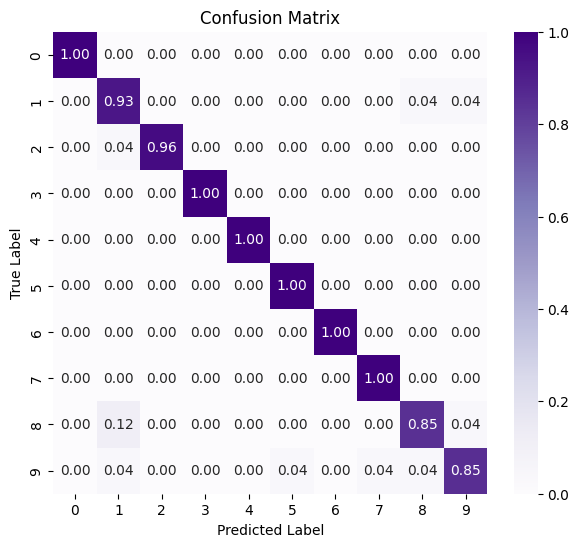

In [111]:
print(f"Macro Precision:  {prec:.4f}")
print(f"Macro Recall:     {rec:.4f}")
print(f"Macro F1-Score:   {f1:.4f}")

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Purples")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()